In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

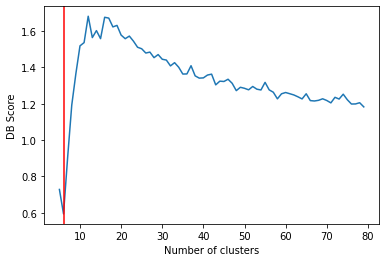

{0, 1, 2, 3, 4, 5}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

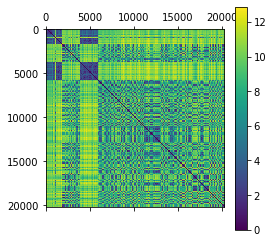

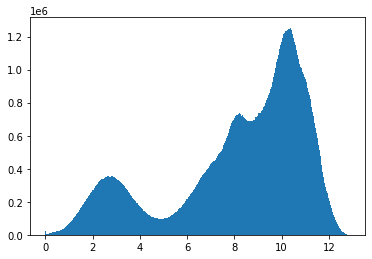

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

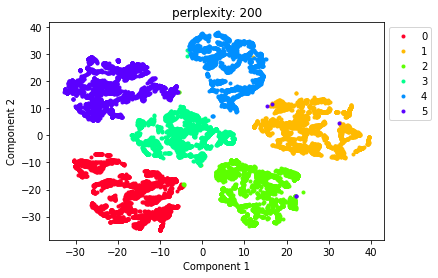

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.978021978021978


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.3451630375907269
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.38630870165745856
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.763 | Reg loss: 0.014 | Tree loss: 1.763 | Accuracy: 0.367500 | 1.483 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.745 | Reg loss: 0.014 | Tree loss: 1.745 | Accuracy: 0.377500 | 0.836 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.739 | Reg loss: 0.014 | Tree loss: 1.739 | Accuracy: 0.347500 | 0.62 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.727 | Reg loss: 0.014 | Tree loss: 1.727 | Accuracy: 0.343000 | 0.515 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.712 | Reg loss: 0.014 | Tree loss: 1.712 | Accuracy: 0.351500 | 0.451 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.693 | Reg loss: 0.014 | Tree loss: 1.693 | Accuracy: 0.373500 | 0.407 sec/iter
Epoch: 00 | Batch: 006 /

Epoch: 05 | Batch: 000 / 011 | Total loss: 1.656 | Reg loss: 0.013 | Tree loss: 1.656 | Accuracy: 0.532500 | 0.403 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.635 | Reg loss: 0.013 | Tree loss: 1.635 | Accuracy: 0.500500 | 0.399 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.607 | Reg loss: 0.013 | Tree loss: 1.607 | Accuracy: 0.493500 | 0.395 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.571 | Reg loss: 0.013 | Tree loss: 1.571 | Accuracy: 0.527000 | 0.392 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.556 | Reg loss: 0.014 | Tree loss: 1.556 | Accuracy: 0.521500 | 0.389 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.536 | Reg loss: 0.014 | Tree loss: 1.536 | Accuracy: 0.558000 | 0.385 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 1.502 | Reg loss: 0.014 | Tree loss: 1.502 | Accuracy: 0.590000 | 0.382 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 1.483 | Reg loss: 0.015 | Tree loss: 1.483 | Accuracy: 0.604000 | 0.379 sec/iter
Epoch: 0

Epoch: 10 | Batch: 002 / 011 | Total loss: 1.399 | Reg loss: 0.016 | Tree loss: 1.399 | Accuracy: 0.591500 | 0.366 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.376 | Reg loss: 0.017 | Tree loss: 1.376 | Accuracy: 0.559000 | 0.364 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.324 | Reg loss: 0.017 | Tree loss: 1.324 | Accuracy: 0.575500 | 0.363 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.310 | Reg loss: 0.017 | Tree loss: 1.310 | Accuracy: 0.595500 | 0.362 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.257 | Reg loss: 0.017 | Tree loss: 1.257 | Accuracy: 0.668000 | 0.361 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.229 | Reg loss: 0.018 | Tree loss: 1.229 | Accuracy: 0.678000 | 0.359 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.211 | Reg loss: 0.018 | Tree loss: 1.211 | Accuracy: 0.696000 | 0.359 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.193 | Reg loss: 0.018 | Tree loss: 1.193 | Accuracy: 0.697500 | 0.357 sec/iter
Epoch: 1

Epoch: 15 | Batch: 004 / 011 | Total loss: 1.097 | Reg loss: 0.019 | Tree loss: 1.097 | Accuracy: 0.704000 | 0.381 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.099 | Reg loss: 0.019 | Tree loss: 1.099 | Accuracy: 0.720000 | 0.381 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.055 | Reg loss: 0.020 | Tree loss: 1.055 | Accuracy: 0.751000 | 0.38 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.035 | Reg loss: 0.020 | Tree loss: 1.035 | Accuracy: 0.750500 | 0.379 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.028 | Reg loss: 0.020 | Tree loss: 1.028 | Accuracy: 0.750000 | 0.378 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 1.008 | Reg loss: 0.020 | Tree loss: 1.008 | Accuracy: 0.755000 | 0.377 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.015 | Reg loss: 0.020 | Tree loss: 1.015 | Accuracy: 0.744027 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0

Epoch: 20 | Batch: 006 / 011 | Total loss: 0.925 | Reg loss: 0.021 | Tree loss: 0.925 | Accuracy: 0.784000 | 0.385 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 0.914 | Reg loss: 0.021 | Tree loss: 0.914 | Accuracy: 0.785000 | 0.384 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 0.902 | Reg loss: 0.021 | Tree loss: 0.902 | Accuracy: 0.767500 | 0.383 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 0.888 | Reg loss: 0.021 | Tree loss: 0.888 | Accuracy: 0.792000 | 0.383 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 0.844 | Reg loss: 0.021 | Tree loss: 0.844 | Accuracy: 0.839590 | 0.382 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.090 | Reg loss: 0.021 | Tree loss: 1.090 | Accuracy: 0.590500 | 0.389 sec/iter
Epoch: 21 | Batch: 00

Epoch: 25 | Batch: 009 / 011 | Total loss: 0.793 | Reg loss: 0.022 | Tree loss: 0.793 | Accuracy: 0.821500 | 0.392 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 0.842 | Reg loss: 0.022 | Tree loss: 0.842 | Accuracy: 0.812287 | 0.391 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.014 | Reg loss: 0.022 | Tree loss: 1.014 | Accuracy: 0.647500 | 0.39 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 0.949 | Reg loss: 0.022 | Tree loss: 0.949 | Accuracy: 0.664000 | 0.39 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 0.910 | Reg loss: 0.022 | Tree loss: 0.910 | Accuracy: 0.717000 | 0.389 sec/iter
Epoch: 26 | Batch: 003 / 011 | Total loss: 0.875 | Reg loss: 0.022 | Tree loss: 0.875 | Accuracy: 0.768500 | 0.389 sec/iter
Epoch: 26 | Batch: 004 

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 31 | Batch: 000 / 011 | Total loss: 0.901 | Reg loss: 0.022 | Tree loss: 0.901 | Accuracy: 0.711500 | 0.397 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.022 | Tree loss: 0.872 | Accuracy: 0.734000 | 0.397 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.022 | Tree loss: 0.849 | Accuracy: 0.763000 | 0.396 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 0.809 | Reg loss: 0.022 | Tree loss: 0.809 | Accuracy: 0.804500 | 0.395 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 0.789 | Reg loss: 0.023 | Tree loss: 0.789 | Accuracy: 0.817500 | 0.395 sec/iter
Epoch: 31 | Batch: 005 / 011 | Total loss: 0.765 | Reg loss: 0.023 | Tree loss: 0.765 | Accuracy: 0.837500 | 0.394 sec/iter
Epoch: 31 | Batch: 00

layer 6: 0.9723756906077349
Epoch: 36 | Batch: 000 / 011 | Total loss: 0.850 | Reg loss: 0.023 | Tree loss: 0.850 | Accuracy: 0.731500 | 0.384 sec/iter
Epoch: 36 | Batch: 001 / 011 | Total loss: 0.811 | Reg loss: 0.023 | Tree loss: 0.811 | Accuracy: 0.741500 | 0.384 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.023 | Tree loss: 0.782 | Accuracy: 0.787000 | 0.383 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.023 | Tree loss: 0.767 | Accuracy: 0.789000 | 0.383 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 0.743 | Reg loss: 0.023 | Tree loss: 0.743 | Accuracy: 0.814500 | 0.382 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.719 | Reg loss: 0.023 | Tree loss: 0.719 | Accuracy: 0.827000 | 0.382 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.687 | Reg loss: 0.023 | Tree loss: 0.687 | Accuracy: 0.840500 | 0.381 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.692 | Reg loss: 0.023 | Tree loss: 0.692 | Accuracy: 0.8480

Epoch: 41 | Batch: 002 / 011 | Total loss: 0.735 | Reg loss: 0.023 | Tree loss: 0.735 | Accuracy: 0.789500 | 0.384 sec/iter
Epoch: 41 | Batch: 003 / 011 | Total loss: 0.711 | Reg loss: 0.023 | Tree loss: 0.711 | Accuracy: 0.791000 | 0.383 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.681 | Reg loss: 0.023 | Tree loss: 0.681 | Accuracy: 0.811500 | 0.383 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.685 | Reg loss: 0.023 | Tree loss: 0.685 | Accuracy: 0.812500 | 0.382 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.669 | Reg loss: 0.023 | Tree loss: 0.669 | Accuracy: 0.837500 | 0.382 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.653 | Reg loss: 0.024 | Tree loss: 0.653 | Accuracy: 0.836500 | 0.382 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.647 | Reg loss: 0.024 | Tree loss: 0.647 | Accuracy: 0.851500 | 0.381 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.650 | Reg loss: 0.024 | Tree loss: 0.650 | Accuracy: 0.841000 | 0.381 sec/iter
Epoch: 4

Epoch: 46 | Batch: 004 / 011 | Total loss: 0.663 | Reg loss: 0.024 | Tree loss: 0.663 | Accuracy: 0.804500 | 0.389 sec/iter
Epoch: 46 | Batch: 005 / 011 | Total loss: 0.652 | Reg loss: 0.024 | Tree loss: 0.652 | Accuracy: 0.827500 | 0.389 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.636 | Reg loss: 0.024 | Tree loss: 0.636 | Accuracy: 0.839500 | 0.389 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.606 | Reg loss: 0.024 | Tree loss: 0.606 | Accuracy: 0.850000 | 0.388 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.619 | Reg loss: 0.024 | Tree loss: 0.619 | Accuracy: 0.850000 | 0.388 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.614 | Reg loss: 0.024 | Tree loss: 0.614 | Accuracy: 0.859000 | 0.387 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.607 | Reg loss: 0.024 | Tree loss: 0.607 | Accuracy: 0.836177 | 0.387 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 51 | Batch: 007 / 011 | Total loss: 0.589 | Reg loss: 0.024 | Tree loss: 0.589 | Accuracy: 0.854000 | 0.388 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.605 | Reg loss: 0.024 | Tree loss: 0.605 | Accuracy: 0.855500 | 0.388 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.597 | Reg loss: 0.024 | Tree loss: 0.597 | Accuracy: 0.841000 | 0.388 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.577 | Reg loss: 0.024 | Tree loss: 0.577 | Accuracy: 0.856655 | 0.387 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.730 | Reg loss: 0.024 | Tree loss: 0.730 | Accuracy: 0.755500 | 0.391 sec/iter
Epoch: 52 | Batch: 001 / 011 | Total loss: 0.703 | Reg loss: 0.024 | Tree loss: 0.703 | Accuracy: 0.783500 | 0.391 sec/iter
Epoch: 52 | Batch: 00

Epoch: 56 | Batch: 009 / 011 | Total loss: 0.578 | Reg loss: 0.025 | Tree loss: 0.578 | Accuracy: 0.837500 | 0.388 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.550 | Reg loss: 0.025 | Tree loss: 0.550 | Accuracy: 0.880546 | 0.388 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.711 | Reg loss: 0.025 | Tree loss: 0.711 | Accuracy: 0.756500 | 0.391 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.691 | Reg loss: 0.025 | Tree loss: 0.691 | Accuracy: 0.772500 | 0.391 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.649 | Reg loss: 0.025 | Tree loss: 0.649 | Accuracy: 0.796000 | 0.391 sec/iter
Epoch: 57 | Batch: 003 / 011 | Total loss: 0.644 | Reg loss: 0.025 | Tree loss: 0.644 | Accuracy: 0.805000 | 0.39 sec/iter
Epoch: 57 | Batch: 004

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.681 | Reg loss: 0.025 | Tree loss: 0.681 | Accuracy: 0.767000 | 0.39 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.656 | Reg loss: 0.025 | Tree loss: 0.656 | Accuracy: 0.791000 | 0.389 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.654 | Reg loss: 0.025 | Tree loss: 0.654 | Accuracy: 0.796500 | 0.389 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.624 | Reg loss: 0.025 | Tree loss: 0.624 | Accuracy: 0.804000 | 0.389 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.619 | Reg loss: 0.025 | Tree loss: 0.619 | Accuracy: 0.794000 | 0.388 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.586 | Reg loss: 0.025 | Tree loss: 0.586 | Accuracy: 0.826000 | 0.388 sec/iter
Epoch: 62 | Batch: 006

layer 6: 0.9723756906077349
Epoch: 67 | Batch: 000 / 011 | Total loss: 0.676 | Reg loss: 0.025 | Tree loss: 0.676 | Accuracy: 0.770000 | 0.39 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.678 | Reg loss: 0.025 | Tree loss: 0.678 | Accuracy: 0.763000 | 0.389 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.628 | Reg loss: 0.025 | Tree loss: 0.628 | Accuracy: 0.805500 | 0.389 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.598 | Reg loss: 0.025 | Tree loss: 0.598 | Accuracy: 0.812500 | 0.389 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.585 | Reg loss: 0.025 | Tree loss: 0.585 | Accuracy: 0.818500 | 0.389 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.839000 | 0.388 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.558 | Reg loss: 0.025 | Tree loss: 0.558 | Accuracy: 0.847000 | 0.388 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.550 | Reg loss: 0.025 | Tree loss: 0.550 | Accuracy: 0.84750

Epoch: 72 | Batch: 002 / 011 | Total loss: 0.620 | Reg loss: 0.025 | Tree loss: 0.620 | Accuracy: 0.805000 | 0.389 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.590 | Reg loss: 0.025 | Tree loss: 0.590 | Accuracy: 0.815000 | 0.389 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.578 | Reg loss: 0.025 | Tree loss: 0.578 | Accuracy: 0.824000 | 0.388 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.824500 | 0.388 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.532 | Reg loss: 0.025 | Tree loss: 0.532 | Accuracy: 0.853000 | 0.388 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.544 | Reg loss: 0.025 | Tree loss: 0.544 | Accuracy: 0.840000 | 0.388 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.527 | Reg loss: 0.025 | Tree loss: 0.527 | Accuracy: 0.854000 | 0.387 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.549 | Reg loss: 0.025 | Tree loss: 0.549 | Accuracy: 0.841500 | 0.387 sec/iter
Epoch: 7

Epoch: 77 | Batch: 004 / 011 | Total loss: 0.557 | Reg loss: 0.025 | Tree loss: 0.557 | Accuracy: 0.828000 | 0.389 sec/iter
Epoch: 77 | Batch: 005 / 011 | Total loss: 0.566 | Reg loss: 0.025 | Tree loss: 0.566 | Accuracy: 0.832500 | 0.388 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.552 | Reg loss: 0.025 | Tree loss: 0.552 | Accuracy: 0.845000 | 0.388 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.544 | Reg loss: 0.025 | Tree loss: 0.544 | Accuracy: 0.840500 | 0.388 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.540 | Reg loss: 0.026 | Tree loss: 0.540 | Accuracy: 0.842000 | 0.388 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.537 | Reg loss: 0.026 | Tree loss: 0.537 | Accuracy: 0.849500 | 0.388 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.511 | Reg loss: 0.026 | Tree loss: 0.511 | Accuracy: 0.866894 | 0.387 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 82 | Batch: 006 / 011 | Total loss: 0.526 | Reg loss: 0.026 | Tree loss: 0.526 | Accuracy: 0.843500 | 0.391 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 0.526 | Reg loss: 0.026 | Tree loss: 0.526 | Accuracy: 0.842000 | 0.391 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.531 | Reg loss: 0.026 | Tree loss: 0.531 | Accuracy: 0.840000 | 0.391 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.534 | Reg loss: 0.026 | Tree loss: 0.534 | Accuracy: 0.843500 | 0.39 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.572 | Reg loss: 0.026 | Tree loss: 0.572 | Accuracy: 0.843003 | 0.39 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.647 | Reg loss: 0.026 | Tree loss: 0.647 | Accuracy: 0.783500 | 0.393 sec/iter
Epoch: 83 | Batch: 001 

Epoch: 87 | Batch: 008 / 011 | Total loss: 0.527 | Reg loss: 0.026 | Tree loss: 0.527 | Accuracy: 0.847500 | 0.386 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.512 | Reg loss: 0.026 | Tree loss: 0.512 | Accuracy: 0.849000 | 0.386 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.511 | Reg loss: 0.026 | Tree loss: 0.511 | Accuracy: 0.856655 | 0.385 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.626 | Reg loss: 0.026 | Tree loss: 0.626 | Accuracy: 0.796500 | 0.388 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.632 | Reg loss: 0.026 | Tree loss: 0.632 | Accuracy: 0.787500 | 0.388 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.599 | Reg loss: 0.026 | Tree loss: 0.599 | Accuracy: 0.810000 | 0.388 sec/iter
Epoch: 88 | Batch: 00

Epoch: 92 | Batch: 010 / 011 | Total loss: 0.530 | Reg loss: 0.026 | Tree loss: 0.530 | Accuracy: 0.829352 | 0.386 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.631 | Reg loss: 0.026 | Tree loss: 0.631 | Accuracy: 0.777000 | 0.388 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.026 | Tree loss: 0.602 | Accuracy: 0.810500 | 0.388 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.582 | Reg loss: 0.026 | Tree loss: 0.582 | Accuracy: 0.812000 | 0.388 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.575 | Reg loss: 0.026 | Tree loss: 0.575 | Accuracy: 0.804500 | 0.387 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.546 | Reg loss: 0.026 | Tree loss: 0.546 | Accuracy: 0.827500 | 0.387 sec/iter
Epoch: 93 | Batch: 00

Epoch: 98 | Batch: 000 / 011 | Total loss: 0.634 | Reg loss: 0.026 | Tree loss: 0.634 | Accuracy: 0.776500 | 0.388 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.611 | Reg loss: 0.026 | Tree loss: 0.611 | Accuracy: 0.803000 | 0.388 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.575 | Reg loss: 0.026 | Tree loss: 0.575 | Accuracy: 0.796000 | 0.388 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.542 | Reg loss: 0.026 | Tree loss: 0.542 | Accuracy: 0.824500 | 0.387 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.541 | Reg loss: 0.026 | Tree loss: 0.541 | Accuracy: 0.825500 | 0.387 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.519 | Reg loss: 0.026 | Tree loss: 0.519 | Accuracy: 0.838000 | 0.387 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.844500 | 0.387 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.512 | Reg loss: 0.026 | Tree loss: 0.512 | Accuracy: 0.843000 | 0.387 sec/iter
Epoch: 9

Epoch: 103 | Batch: 002 / 011 | Total loss: 0.586 | Reg loss: 0.026 | Tree loss: 0.586 | Accuracy: 0.805500 | 0.388 sec/iter
Epoch: 103 | Batch: 003 / 011 | Total loss: 0.567 | Reg loss: 0.026 | Tree loss: 0.567 | Accuracy: 0.796500 | 0.388 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.538 | Reg loss: 0.026 | Tree loss: 0.538 | Accuracy: 0.820000 | 0.388 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.519 | Reg loss: 0.026 | Tree loss: 0.519 | Accuracy: 0.831000 | 0.388 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.510 | Reg loss: 0.026 | Tree loss: 0.510 | Accuracy: 0.847500 | 0.387 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.506 | Reg loss: 0.026 | Tree loss: 0.506 | Accuracy: 0.849000 | 0.387 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.512 | Reg loss: 0.026 | Tree loss: 0.512 | Accuracy: 0.837000 | 0.387 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.501 | Reg loss: 0.026 | Tree loss: 0.501 | Accuracy: 0.853500 | 0.387 sec/iter


Epoch: 108 | Batch: 004 / 011 | Total loss: 0.538 | Reg loss: 0.026 | Tree loss: 0.538 | Accuracy: 0.829000 | 0.39 sec/iter
Epoch: 108 | Batch: 005 / 011 | Total loss: 0.506 | Reg loss: 0.026 | Tree loss: 0.506 | Accuracy: 0.845000 | 0.39 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.526 | Reg loss: 0.026 | Tree loss: 0.526 | Accuracy: 0.837500 | 0.39 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.508 | Reg loss: 0.026 | Tree loss: 0.508 | Accuracy: 0.841500 | 0.39 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.507 | Reg loss: 0.026 | Tree loss: 0.507 | Accuracy: 0.845500 | 0.389 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.497 | Reg loss: 0.026 | Tree loss: 0.497 | Accuracy: 0.864500 | 0.389 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.458 | Reg loss: 0.026 | Tree loss: 0.458 | Accuracy: 0.866894 | 0.389 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 

Epoch: 113 | Batch: 006 / 011 | Total loss: 0.501 | Reg loss: 0.026 | Tree loss: 0.501 | Accuracy: 0.848500 | 0.386 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.501 | Reg loss: 0.026 | Tree loss: 0.501 | Accuracy: 0.855500 | 0.386 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.499 | Reg loss: 0.026 | Tree loss: 0.499 | Accuracy: 0.845000 | 0.386 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.497 | Reg loss: 0.026 | Tree loss: 0.497 | Accuracy: 0.850000 | 0.386 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.513 | Reg loss: 0.026 | Tree loss: 0.513 | Accuracy: 0.825939 | 0.386 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 114 | Batch: 000 / 011 | Total loss: 0.598 | Reg loss: 0.026 | Tree loss: 0.598 | Accuracy: 0.802000 | 0.387 sec/iter
Epoch: 114 | Ba

Epoch: 118 | Batch: 008 / 011 | Total loss: 0.494 | Reg loss: 0.026 | Tree loss: 0.494 | Accuracy: 0.854000 | 0.386 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.501 | Reg loss: 0.026 | Tree loss: 0.501 | Accuracy: 0.858500 | 0.386 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.502 | Reg loss: 0.026 | Tree loss: 0.502 | Accuracy: 0.860068 | 0.385 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.621 | Reg loss: 0.026 | Tree loss: 0.621 | Accuracy: 0.791500 | 0.386 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.602 | Reg loss: 0.026 | Tree loss: 0.602 | Accuracy: 0.799000 | 0.386 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.026 | Tree loss: 0.552 | Accuracy: 0.814000 | 0.386 sec/iter
Epoch: 119 | Ba

Epoch: 123 | Batch: 010 / 011 | Total loss: 0.539 | Reg loss: 0.026 | Tree loss: 0.539 | Accuracy: 0.843003 | 0.386 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.624 | Reg loss: 0.026 | Tree loss: 0.624 | Accuracy: 0.786000 | 0.388 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.026 | Tree loss: 0.571 | Accuracy: 0.820000 | 0.388 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.564 | Reg loss: 0.026 | Tree loss: 0.564 | Accuracy: 0.815500 | 0.387 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.548 | Reg loss: 0.026 | Tree loss: 0.548 | Accuracy: 0.810500 | 0.387 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.826500 | 0.387 sec/iter
Epoch: 124 | Ba

layer 6: 0.9723756906077349
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.623 | Reg loss: 0.026 | Tree loss: 0.623 | Accuracy: 0.798500 | 0.39 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.564 | Reg loss: 0.026 | Tree loss: 0.564 | Accuracy: 0.808000 | 0.389 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.561 | Reg loss: 0.026 | Tree loss: 0.561 | Accuracy: 0.807500 | 0.389 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.514 | Reg loss: 0.026 | Tree loss: 0.514 | Accuracy: 0.838500 | 0.389 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.521 | Reg loss: 0.026 | Tree loss: 0.521 | Accuracy: 0.823500 | 0.389 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.494 | Reg loss: 0.026 | Tree loss: 0.494 | Accuracy: 0.856000 | 0.389 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.507 | Reg loss: 0.026 | Tree loss: 0.507 | Accuracy: 0.844500 | 0.389 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.506 | Reg loss: 0.026 | Tree loss: 0.506 | Accuracy:

Epoch: 134 | Batch: 002 / 011 | Total loss: 0.567 | Reg loss: 0.026 | Tree loss: 0.567 | Accuracy: 0.813000 | 0.39 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.544 | Reg loss: 0.026 | Tree loss: 0.544 | Accuracy: 0.811500 | 0.39 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.835000 | 0.389 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.842000 | 0.389 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.503 | Reg loss: 0.026 | Tree loss: 0.503 | Accuracy: 0.837000 | 0.389 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.026 | Tree loss: 0.481 | Accuracy: 0.860500 | 0.389 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.508 | Reg loss: 0.026 | Tree loss: 0.508 | Accuracy: 0.833500 | 0.389 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.026 | Tree loss: 0.471 | Accuracy: 0.865500 | 0.389 sec/iter
Ep

Epoch: 139 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.026 | Tree loss: 0.505 | Accuracy: 0.836000 | 0.389 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.499 | Reg loss: 0.026 | Tree loss: 0.499 | Accuracy: 0.843500 | 0.389 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.486 | Reg loss: 0.026 | Tree loss: 0.486 | Accuracy: 0.858500 | 0.389 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.484 | Reg loss: 0.026 | Tree loss: 0.484 | Accuracy: 0.851500 | 0.389 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.485 | Reg loss: 0.026 | Tree loss: 0.485 | Accuracy: 0.856500 | 0.389 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.493 | Reg loss: 0.026 | Tree loss: 0.493 | Accuracy: 0.851000 | 0.388 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.502 | Reg loss: 0.026 | Tree loss: 0.502 | Accuracy: 0.839590 | 0.388 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 144 | Batch: 006 / 011 | Total loss: 0.475 | Reg loss: 0.026 | Tree loss: 0.475 | Accuracy: 0.861500 | 0.39 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.835000 | 0.39 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.487 | Reg loss: 0.026 | Tree loss: 0.487 | Accuracy: 0.858500 | 0.389 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.483 | Reg loss: 0.026 | Tree loss: 0.483 | Accuracy: 0.859000 | 0.389 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.463 | Reg loss: 0.026 | Tree loss: 0.463 | Accuracy: 0.870307 | 0.389 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 145 | Batch: 000 / 011 | Total loss: 0.588 | Reg loss: 0.026 | Tree loss: 0.588 | Accuracy: 0.806000 | 0.391 sec/iter
Epoch: 145 | Batc

Epoch: 149 | Batch: 008 / 011 | Total loss: 0.483 | Reg loss: 0.026 | Tree loss: 0.483 | Accuracy: 0.859000 | 0.389 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.489 | Reg loss: 0.026 | Tree loss: 0.489 | Accuracy: 0.861500 | 0.388 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.470 | Reg loss: 0.026 | Tree loss: 0.470 | Accuracy: 0.839590 | 0.388 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.586 | Reg loss: 0.026 | Tree loss: 0.586 | Accuracy: 0.808000 | 0.39 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.026 | Tree loss: 0.565 | Accuracy: 0.810000 | 0.39 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.559 | Reg loss: 0.026 | Tree loss: 0.559 | Accuracy: 0.800500 | 0.389 sec/iter
Epoch: 150 | Batc

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.587 | Reg loss: 0.026 | Tree loss: 0.587 | Accuracy: 0.804500 | 0.389 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.578 | Reg loss: 0.026 | Tree loss: 0.578 | Accuracy: 0.798500 | 0.389 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.550 | Reg loss: 0.026 | Tree loss: 0.550 | Accuracy: 0.822000 | 0.389 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.542 | Reg loss: 0.026 | Tree loss: 0.542 | Accuracy: 0.811500 | 0.389 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.827000 | 0.389 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 0.499 | Reg loss: 0.026 | Tree loss: 0.499 | Accuracy: 0.840000 | 0.389 sec/iter
Epoch: 155 | Ba

layer 6: 0.9723756906077349
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.574 | Reg loss: 0.026 | Tree loss: 0.574 | Accuracy: 0.814000 | 0.387 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.026 | Tree loss: 0.582 | Accuracy: 0.805500 | 0.387 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.548 | Reg loss: 0.026 | Tree loss: 0.548 | Accuracy: 0.814500 | 0.387 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.543 | Reg loss: 0.026 | Tree loss: 0.543 | Accuracy: 0.810000 | 0.387 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.516 | Reg loss: 0.026 | Tree loss: 0.516 | Accuracy: 0.837500 | 0.387 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.504 | Reg loss: 0.026 | Tree loss: 0.504 | Accuracy: 0.843000 | 0.387 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.474 | Reg loss: 0.026 | Tree loss: 0.474 | Accuracy: 0.859000 | 0.387 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.484 | Reg loss: 0.026 | Tree loss: 0.484 | Accuracy

Epoch: 165 | Batch: 001 / 011 | Total loss: 0.585 | Reg loss: 0.026 | Tree loss: 0.585 | Accuracy: 0.799500 | 0.388 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.578 | Reg loss: 0.026 | Tree loss: 0.578 | Accuracy: 0.796500 | 0.388 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.523 | Reg loss: 0.026 | Tree loss: 0.523 | Accuracy: 0.829000 | 0.388 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.512 | Reg loss: 0.026 | Tree loss: 0.512 | Accuracy: 0.829000 | 0.388 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.831000 | 0.388 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.502 | Reg loss: 0.026 | Tree loss: 0.502 | Accuracy: 0.845500 | 0.387 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.478 | Reg loss: 0.026 | Tree loss: 0.478 | Accuracy: 0.859000 | 0.387 sec/iter
Epoch: 165 | Batch: 008 / 011 | Total loss: 0.466 | Reg loss: 0.026 | Tree loss: 0.466 | Accuracy: 0.868500 | 0.387 sec/iter


Epoch: 170 | Batch: 004 / 011 | Total loss: 0.507 | Reg loss: 0.026 | Tree loss: 0.507 | Accuracy: 0.839500 | 0.387 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.511 | Reg loss: 0.026 | Tree loss: 0.511 | Accuracy: 0.840500 | 0.387 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.476 | Reg loss: 0.026 | Tree loss: 0.476 | Accuracy: 0.861500 | 0.387 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.466 | Reg loss: 0.026 | Tree loss: 0.466 | Accuracy: 0.864500 | 0.386 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.491 | Reg loss: 0.026 | Tree loss: 0.491 | Accuracy: 0.848000 | 0.386 sec/iter
Epoch: 170 | Batch: 009 / 011 | Total loss: 0.479 | Reg loss: 0.026 | Tree loss: 0.479 | Accuracy: 0.861500 | 0.386 sec/iter
Epoch: 170 | Batch: 010 / 011 | Total loss: 0.451 | Reg loss: 0.026 | Tree loss: 0.451 | Accuracy: 0.866894 | 0.386 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 175 | Batch: 006 / 011 | Total loss: 0.478 | Reg loss: 0.026 | Tree loss: 0.478 | Accuracy: 0.853500 | 0.386 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.485 | Reg loss: 0.026 | Tree loss: 0.485 | Accuracy: 0.855500 | 0.386 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.492 | Reg loss: 0.026 | Tree loss: 0.492 | Accuracy: 0.865000 | 0.386 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.478 | Reg loss: 0.026 | Tree loss: 0.478 | Accuracy: 0.855000 | 0.385 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.440 | Reg loss: 0.026 | Tree loss: 0.440 | Accuracy: 0.877133 | 0.385 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 176 | Batch: 000 / 011 | Total loss: 0.596 | Reg loss: 0.026 | Tree loss: 0.596 | Accuracy: 0.806500 | 0.386 sec/iter
Epoch: 176 | Ba

Epoch: 180 | Batch: 008 / 011 | Total loss: 0.480 | Reg loss: 0.026 | Tree loss: 0.480 | Accuracy: 0.851000 | 0.385 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.026 | Tree loss: 0.471 | Accuracy: 0.862000 | 0.385 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.473 | Reg loss: 0.026 | Tree loss: 0.473 | Accuracy: 0.890785 | 0.385 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 181 | Batch: 000 / 011 | Total loss: 0.575 | Reg loss: 0.026 | Tree loss: 0.575 | Accuracy: 0.824500 | 0.386 sec/iter
Epoch: 181 | Batch: 001 / 011 | Total loss: 0.566 | Reg loss: 0.026 | Tree loss: 0.566 | Accuracy: 0.808000 | 0.386 sec/iter
Epoch: 181 | Batch: 002 / 011 | Total loss: 0.579 | Reg loss: 0.026 | Tree loss: 0.579 | Accuracy: 0.796500 | 0.386 sec/iter
Epoch: 181 | Ba

Epoch: 185 | Batch: 010 / 011 | Total loss: 0.492 | Reg loss: 0.026 | Tree loss: 0.492 | Accuracy: 0.849829 | 0.383 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.588 | Reg loss: 0.025 | Tree loss: 0.588 | Accuracy: 0.818000 | 0.384 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.025 | Tree loss: 0.571 | Accuracy: 0.818000 | 0.384 sec/iter
Epoch: 186 | Batch: 002 / 011 | Total loss: 0.560 | Reg loss: 0.025 | Tree loss: 0.560 | Accuracy: 0.809500 | 0.384 sec/iter
Epoch: 186 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.025 | Tree loss: 0.513 | Accuracy: 0.833000 | 0.384 sec/iter
Epoch: 186 | Batch: 004 / 011 | Total loss: 0.499 | Reg loss: 0.026 | Tree loss: 0.499 | Accuracy: 0.834500 | 0.384 sec/iter
Epoch: 186 | Ba

layer 6: 0.9723756906077349
Epoch: 191 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.025 | Tree loss: 0.591 | Accuracy: 0.806000 | 0.385 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.575 | Reg loss: 0.025 | Tree loss: 0.575 | Accuracy: 0.808500 | 0.385 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.569 | Reg loss: 0.025 | Tree loss: 0.569 | Accuracy: 0.802000 | 0.384 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.025 | Tree loss: 0.524 | Accuracy: 0.826000 | 0.384 sec/iter
Epoch: 191 | Batch: 004 / 011 | Total loss: 0.504 | Reg loss: 0.025 | Tree loss: 0.504 | Accuracy: 0.834000 | 0.384 sec/iter
Epoch: 191 | Batch: 005 / 011 | Total loss: 0.514 | Reg loss: 0.025 | Tree loss: 0.514 | Accuracy: 0.830000 | 0.384 sec/iter
Epoch: 191 | Batch: 006 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.855000 | 0.384 sec/iter
Epoch: 191 | Batch: 007 / 011 | Total loss: 0.490 | Reg loss: 0.026 | Tree loss: 0.490 | Accuracy

Epoch: 196 | Batch: 002 / 011 | Total loss: 0.541 | Reg loss: 0.025 | Tree loss: 0.541 | Accuracy: 0.818000 | 0.384 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.521 | Reg loss: 0.025 | Tree loss: 0.521 | Accuracy: 0.826000 | 0.384 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.507 | Reg loss: 0.025 | Tree loss: 0.507 | Accuracy: 0.835500 | 0.384 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.025 | Tree loss: 0.497 | Accuracy: 0.829000 | 0.384 sec/iter
Epoch: 196 | Batch: 006 / 011 | Total loss: 0.494 | Reg loss: 0.025 | Tree loss: 0.494 | Accuracy: 0.849500 | 0.384 sec/iter
Epoch: 196 | Batch: 007 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.863000 | 0.384 sec/iter
Epoch: 196 | Batch: 008 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.870000 | 0.384 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.864000 | 0.384 sec/iter


Epoch: 201 | Batch: 004 / 011 | Total loss: 0.531 | Reg loss: 0.025 | Tree loss: 0.531 | Accuracy: 0.812500 | 0.384 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.845500 | 0.384 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.842000 | 0.383 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.861500 | 0.383 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.850500 | 0.383 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.845000 | 0.383 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.512 | Reg loss: 0.025 | Tree loss: 0.512 | Accuracy: 0.832765 | 0.383 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 206 | Batch: 006 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.848500 | 0.383 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.855500 | 0.383 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.849500 | 0.383 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.873500 | 0.383 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.849829 | 0.383 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 207 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.817000 | 0.383 sec/iter
Epoch: 207 | Ba

Epoch: 211 | Batch: 008 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.872500 | 0.382 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.854500 | 0.382 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.873720 | 0.382 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 212 | Batch: 000 / 011 | Total loss: 0.576 | Reg loss: 0.025 | Tree loss: 0.576 | Accuracy: 0.816500 | 0.382 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.025 | Tree loss: 0.565 | Accuracy: 0.813500 | 0.382 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 0.538 | Reg loss: 0.025 | Tree loss: 0.538 | Accuracy: 0.807500 | 0.382 sec/iter
Epoch: 212 | Ba

Epoch: 216 | Batch: 010 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy: 0.877133 | 0.382 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.604 | Reg loss: 0.025 | Tree loss: 0.604 | Accuracy: 0.801000 | 0.383 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.025 | Tree loss: 0.571 | Accuracy: 0.805000 | 0.383 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 0.533 | Reg loss: 0.025 | Tree loss: 0.533 | Accuracy: 0.820500 | 0.383 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 0.527 | Reg loss: 0.025 | Tree loss: 0.527 | Accuracy: 0.815500 | 0.383 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 0.501 | Reg loss: 0.025 | Tree loss: 0.501 | Accuracy: 0.831500 | 0.383 sec/iter
Epoch: 217 | Ba

Epoch: 222 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.810500 | 0.383 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.803000 | 0.383 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.535 | Reg loss: 0.025 | Tree loss: 0.535 | Accuracy: 0.822500 | 0.383 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 0.540 | Reg loss: 0.025 | Tree loss: 0.540 | Accuracy: 0.809000 | 0.383 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 0.513 | Reg loss: 0.025 | Tree loss: 0.513 | Accuracy: 0.826000 | 0.382 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.841000 | 0.382 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.852500 | 0.382 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.859500 | 0.382 sec/iter


Epoch: 227 | Batch: 002 / 011 | Total loss: 0.550 | Reg loss: 0.025 | Tree loss: 0.550 | Accuracy: 0.813000 | 0.383 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.529 | Reg loss: 0.025 | Tree loss: 0.529 | Accuracy: 0.824000 | 0.383 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.492 | Reg loss: 0.025 | Tree loss: 0.492 | Accuracy: 0.843500 | 0.383 sec/iter
Epoch: 227 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.851500 | 0.383 sec/iter
Epoch: 227 | Batch: 006 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.858000 | 0.383 sec/iter
Epoch: 227 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.853500 | 0.383 sec/iter
Epoch: 227 | Batch: 008 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.865000 | 0.383 sec/iter
Epoch: 227 | Batch: 009 / 011 | Total loss: 0.469 | Reg loss: 0.025 | Tree loss: 0.469 | Accuracy: 0.860500 | 0.383 sec/iter


Epoch: 232 | Batch: 004 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.838500 | 0.382 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.830500 | 0.382 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.851500 | 0.382 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.843000 | 0.382 sec/iter
Epoch: 232 | Batch: 008 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.861500 | 0.382 sec/iter
Epoch: 232 | Batch: 009 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.865500 | 0.382 sec/iter
Epoch: 232 | Batch: 010 / 011 | Total loss: 0.434 | Reg loss: 0.025 | Tree loss: 0.434 | Accuracy: 0.887372 | 0.382 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 237 | Batch: 006 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.852000 | 0.382 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.864500 | 0.382 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy: 0.867000 | 0.382 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.863000 | 0.382 sec/iter
Epoch: 237 | Batch: 010 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.832765 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 238 | Batch: 000 / 011 | Total loss: 0.576 | Reg loss: 0.025 | Tree loss: 0.576 | Accuracy: 0.819500 | 0.382 sec/iter
Epoch: 238 | Ba

Epoch: 242 | Batch: 008 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.840500 | 0.381 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.857000 | 0.381 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.863481 | 0.381 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 243 | Batch: 000 / 011 | Total loss: 0.600 | Reg loss: 0.025 | Tree loss: 0.600 | Accuracy: 0.802500 | 0.382 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.814000 | 0.382 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 0.537 | Reg loss: 0.025 | Tree loss: 0.537 | Accuracy: 0.821000 | 0.382 sec/iter
Epoch: 243 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 248 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.807500 | 0.383 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 0.552 | Reg loss: 0.025 | Tree loss: 0.552 | Accuracy: 0.815500 | 0.382 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 0.547 | Reg loss: 0.025 | Tree loss: 0.547 | Accuracy: 0.817500 | 0.382 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 0.511 | Reg loss: 0.025 | Tree loss: 0.511 | Accuracy: 0.840000 | 0.382 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.825000 | 0.382 sec/iter
Epoch: 248 | Batch: 005 / 011 | Total loss: 0.494 | Reg loss: 0.025 | Tree loss: 0.494 | Accuracy: 0.837000 | 0.382 sec/iter
Epoch: 248 | Ba

layer 6: 0.9723756906077349
Epoch: 253 | Batch: 000 / 011 | Total loss: 0.581 | Reg loss: 0.025 | Tree loss: 0.581 | Accuracy: 0.816500 | 0.382 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 0.556 | Reg loss: 0.025 | Tree loss: 0.556 | Accuracy: 0.824500 | 0.382 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.560 | Reg loss: 0.025 | Tree loss: 0.560 | Accuracy: 0.800500 | 0.382 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 0.529 | Reg loss: 0.025 | Tree loss: 0.529 | Accuracy: 0.819000 | 0.382 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.830000 | 0.382 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.848500 | 0.382 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.859000 | 0.382 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy

Epoch: 258 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.025 | Tree loss: 0.552 | Accuracy: 0.817000 | 0.38 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.515 | Reg loss: 0.025 | Tree loss: 0.515 | Accuracy: 0.834500 | 0.38 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.512 | Reg loss: 0.025 | Tree loss: 0.512 | Accuracy: 0.834000 | 0.38 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.854000 | 0.38 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.842000 | 0.38 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.859500 | 0.38 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.855500 | 0.38 sec/iter
Epoch: 258 | Batch: 009 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.871000 | 0.38 sec/iter
Epoch: 2

Epoch: 263 | Batch: 004 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.823500 | 0.381 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.831000 | 0.381 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.859500 | 0.38 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.850500 | 0.38 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.861000 | 0.38 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.865500 | 0.38 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.843003 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3

Epoch: 268 | Batch: 006 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.849000 | 0.38 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.861000 | 0.38 sec/iter
Epoch: 268 | Batch: 008 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.863000 | 0.38 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.860000 | 0.38 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.863481 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.576 | Reg loss: 0.025 | Tree loss: 0.576 | Accuracy: 0.821000 | 0.381 sec/iter
Epoch: 269 | Batch: 

Epoch: 273 | Batch: 008 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.864000 | 0.381 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.857000 | 0.38 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.870307 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.587 | Reg loss: 0.025 | Tree loss: 0.587 | Accuracy: 0.815500 | 0.38 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.546 | Reg loss: 0.025 | Tree loss: 0.546 | Accuracy: 0.824000 | 0.38 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.553 | Reg loss: 0.025 | Tree loss: 0.553 | Accuracy: 0.803500 | 0.38 sec/iter
Epoch: 274 | Batch: 

Epoch: 278 | Batch: 010 / 011 | Total loss: 0.456 | Reg loss: 0.025 | Tree loss: 0.456 | Accuracy: 0.870307 | 0.38 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 279 | Batch: 000 / 011 | Total loss: 0.563 | Reg loss: 0.025 | Tree loss: 0.563 | Accuracy: 0.823500 | 0.381 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 0.557 | Reg loss: 0.025 | Tree loss: 0.557 | Accuracy: 0.821500 | 0.381 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.553 | Reg loss: 0.025 | Tree loss: 0.553 | Accuracy: 0.817500 | 0.381 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.517 | Reg loss: 0.025 | Tree loss: 0.517 | Accuracy: 0.825500 | 0.381 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.519 | Reg loss: 0.025 | Tree loss: 0.519 | Accuracy: 0.821000 | 0.381 sec/iter
Epoch: 279 | Bat

layer 6: 0.9723756906077349
Epoch: 284 | Batch: 000 / 011 | Total loss: 0.592 | Reg loss: 0.025 | Tree loss: 0.592 | Accuracy: 0.813500 | 0.379 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.552 | Reg loss: 0.025 | Tree loss: 0.552 | Accuracy: 0.821000 | 0.379 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.557 | Reg loss: 0.025 | Tree loss: 0.557 | Accuracy: 0.811500 | 0.379 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.835500 | 0.379 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.824500 | 0.379 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.838000 | 0.379 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.848000 | 0.379 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy

Epoch: 289 | Batch: 002 / 011 | Total loss: 0.541 | Reg loss: 0.025 | Tree loss: 0.541 | Accuracy: 0.817000 | 0.379 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.831500 | 0.379 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.825000 | 0.379 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.843500 | 0.379 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.848500 | 0.379 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.856500 | 0.379 sec/iter
Epoch: 289 | Batch: 008 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.869500 | 0.379 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.866000 | 0.379 sec/iter


Epoch: 294 | Batch: 004 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.836000 | 0.379 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.843000 | 0.379 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.854500 | 0.379 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.844000 | 0.379 sec/iter
Epoch: 294 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy: 0.867500 | 0.379 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 0.465 | Reg loss: 0.025 | Tree loss: 0.465 | Accuracy: 0.852000 | 0.379 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 0.504 | Reg loss: 0.025 | Tree loss: 0.504 | Accuracy: 0.832765 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 299 | Batch: 006 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.842500 | 0.379 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.870000 | 0.379 sec/iter
Epoch: 299 | Batch: 008 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.860500 | 0.379 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.870500 | 0.379 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 0.501 | Reg loss: 0.025 | Tree loss: 0.501 | Accuracy: 0.849829 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 300 | Batch: 000 / 011 | Total loss: 0.583 | Reg loss: 0.025 | Tree loss: 0.583 | Accuracy: 0.819000 | 0.379 sec/iter
Epoch: 300 | Ba

Epoch: 304 | Batch: 008 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.871500 | 0.379 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.863500 | 0.379 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 0.445 | Reg loss: 0.025 | Tree loss: 0.445 | Accuracy: 0.863481 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 305 | Batch: 000 / 011 | Total loss: 0.595 | Reg loss: 0.025 | Tree loss: 0.595 | Accuracy: 0.799000 | 0.38 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.025 | Tree loss: 0.543 | Accuracy: 0.829500 | 0.38 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.556 | Reg loss: 0.025 | Tree loss: 0.556 | Accuracy: 0.797000 | 0.38 sec/iter
Epoch: 305 | Batch

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 310 | Batch: 000 / 011 | Total loss: 0.586 | Reg loss: 0.025 | Tree loss: 0.586 | Accuracy: 0.809000 | 0.379 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.573 | Reg loss: 0.025 | Tree loss: 0.573 | Accuracy: 0.799000 | 0.379 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.518 | Reg loss: 0.025 | Tree loss: 0.518 | Accuracy: 0.834500 | 0.379 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.025 | Tree loss: 0.519 | Accuracy: 0.819000 | 0.379 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.025 | Tree loss: 0.506 | Accuracy: 0.825500 | 0.379 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.835000 | 0.379 sec/iter
Epoch: 310 | Ba

layer 6: 0.9723756906077349
Epoch: 315 | Batch: 000 / 011 | Total loss: 0.561 | Reg loss: 0.025 | Tree loss: 0.561 | Accuracy: 0.836000 | 0.38 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.568 | Reg loss: 0.025 | Tree loss: 0.568 | Accuracy: 0.802000 | 0.38 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.556 | Reg loss: 0.025 | Tree loss: 0.556 | Accuracy: 0.801000 | 0.38 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.518 | Reg loss: 0.025 | Tree loss: 0.518 | Accuracy: 0.822000 | 0.38 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.835500 | 0.38 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.841500 | 0.379 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.839000 | 0.379 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.8

Epoch: 320 | Batch: 002 / 011 | Total loss: 0.555 | Reg loss: 0.025 | Tree loss: 0.555 | Accuracy: 0.806000 | 0.379 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.025 | Tree loss: 0.519 | Accuracy: 0.821500 | 0.379 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.515 | Reg loss: 0.025 | Tree loss: 0.515 | Accuracy: 0.827000 | 0.379 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.838500 | 0.379 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.492 | Reg loss: 0.025 | Tree loss: 0.492 | Accuracy: 0.845000 | 0.379 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.453 | Reg loss: 0.025 | Tree loss: 0.453 | Accuracy: 0.872000 | 0.379 sec/iter
Epoch: 320 | Batch: 008 / 011 | Total loss: 0.465 | Reg loss: 0.025 | Tree loss: 0.465 | Accuracy: 0.863500 | 0.379 sec/iter
Epoch: 320 | Batch: 009 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.864500 | 0.379 sec/iter


Epoch: 325 | Batch: 004 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.837500 | 0.379 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.854500 | 0.379 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.848000 | 0.379 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.865500 | 0.379 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.852000 | 0.379 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.854500 | 0.379 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.860068 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 330 | Batch: 006 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.851000 | 0.379 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.861000 | 0.379 sec/iter
Epoch: 330 | Batch: 008 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.844500 | 0.379 sec/iter
Epoch: 330 | Batch: 009 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.869000 | 0.379 sec/iter
Epoch: 330 | Batch: 010 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.873720 | 0.379 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 331 | Batch: 000 / 011 | Total loss: 0.580 | Reg loss: 0.025 | Tree loss: 0.580 | Accuracy: 0.819500 | 0.378 sec/iter
Epoch: 331 | Ba

Epoch: 335 | Batch: 008 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.873500 | 0.378 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.873000 | 0.378 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.860068 | 0.378 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 336 | Batch: 000 / 011 | Total loss: 0.586 | Reg loss: 0.025 | Tree loss: 0.586 | Accuracy: 0.814000 | 0.378 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 0.553 | Reg loss: 0.025 | Tree loss: 0.553 | Accuracy: 0.819000 | 0.378 sec/iter
Epoch: 336 | Batch: 002 / 011 | Total loss: 0.522 | Reg loss: 0.025 | Tree loss: 0.522 | Accuracy: 0.824000 | 0.378 sec/iter
Epoch: 336 | Ba

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 341 | Batch: 000 / 011 | Total loss: 0.581 | Reg loss: 0.025 | Tree loss: 0.581 | Accuracy: 0.816500 | 0.378 sec/iter
Epoch: 341 | Batch: 001 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.804500 | 0.378 sec/iter
Epoch: 341 | Batch: 002 / 011 | Total loss: 0.531 | Reg loss: 0.025 | Tree loss: 0.531 | Accuracy: 0.827000 | 0.378 sec/iter
Epoch: 341 | Batch: 003 / 011 | Total loss: 0.504 | Reg loss: 0.025 | Tree loss: 0.504 | Accuracy: 0.842000 | 0.378 sec/iter
Epoch: 341 | Batch: 004 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.853000 | 0.378 sec/iter
Epoch: 341 | Batch: 005 / 011 | Total loss: 0.487 | Reg loss: 0.025 | Tree loss: 0.487 | Accuracy: 0.838500 | 0.378 sec/iter
Epoch: 341 | Ba

layer 6: 0.9723756906077349
Epoch: 346 | Batch: 000 / 011 | Total loss: 0.566 | Reg loss: 0.025 | Tree loss: 0.566 | Accuracy: 0.831500 | 0.378 sec/iter
Epoch: 346 | Batch: 001 / 011 | Total loss: 0.560 | Reg loss: 0.025 | Tree loss: 0.560 | Accuracy: 0.808000 | 0.378 sec/iter
Epoch: 346 | Batch: 002 / 011 | Total loss: 0.533 | Reg loss: 0.025 | Tree loss: 0.533 | Accuracy: 0.825000 | 0.378 sec/iter
Epoch: 346 | Batch: 003 / 011 | Total loss: 0.535 | Reg loss: 0.025 | Tree loss: 0.535 | Accuracy: 0.818000 | 0.378 sec/iter
Epoch: 346 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.832000 | 0.378 sec/iter
Epoch: 346 | Batch: 005 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.845000 | 0.378 sec/iter
Epoch: 346 | Batch: 006 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.855000 | 0.378 sec/iter
Epoch: 346 | Batch: 007 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy

Epoch: 351 | Batch: 001 / 011 | Total loss: 0.589 | Reg loss: 0.025 | Tree loss: 0.589 | Accuracy: 0.800000 | 0.378 sec/iter
Epoch: 351 | Batch: 002 / 011 | Total loss: 0.565 | Reg loss: 0.025 | Tree loss: 0.565 | Accuracy: 0.803000 | 0.378 sec/iter
Epoch: 351 | Batch: 003 / 011 | Total loss: 0.506 | Reg loss: 0.025 | Tree loss: 0.506 | Accuracy: 0.838000 | 0.378 sec/iter
Epoch: 351 | Batch: 004 / 011 | Total loss: 0.497 | Reg loss: 0.025 | Tree loss: 0.497 | Accuracy: 0.834500 | 0.378 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.854500 | 0.378 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.856000 | 0.378 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.852500 | 0.378 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.856500 | 0.378 sec/iter


Epoch: 356 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.025 | Tree loss: 0.524 | Accuracy: 0.821500 | 0.377 sec/iter
Epoch: 356 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.843500 | 0.377 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.842000 | 0.377 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.856000 | 0.377 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.868000 | 0.377 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.857000 | 0.377 sec/iter
Epoch: 356 | Batch: 009 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.871000 | 0.377 sec/iter
Epoch: 356 | Batch: 010 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.863481 | 0.377 sec/iter


Epoch: 361 | Batch: 006 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.848500 | 0.377 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.864000 | 0.377 sec/iter
Epoch: 361 | Batch: 008 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.856000 | 0.377 sec/iter
Epoch: 361 | Batch: 009 / 011 | Total loss: 0.465 | Reg loss: 0.025 | Tree loss: 0.465 | Accuracy: 0.869500 | 0.377 sec/iter
Epoch: 361 | Batch: 010 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.873720 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 362 | Batch: 000 / 011 | Total loss: 0.595 | Reg loss: 0.025 | Tree loss: 0.595 | Accuracy: 0.801000 | 0.377 sec/iter
Epoch: 362 | Ba

Epoch: 366 | Batch: 008 / 011 | Total loss: 0.448 | Reg loss: 0.025 | Tree loss: 0.448 | Accuracy: 0.883000 | 0.377 sec/iter
Epoch: 366 | Batch: 009 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.866500 | 0.377 sec/iter
Epoch: 366 | Batch: 010 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.870307 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 367 | Batch: 000 / 011 | Total loss: 0.586 | Reg loss: 0.025 | Tree loss: 0.586 | Accuracy: 0.814000 | 0.377 sec/iter
Epoch: 367 | Batch: 001 / 011 | Total loss: 0.544 | Reg loss: 0.025 | Tree loss: 0.544 | Accuracy: 0.823500 | 0.377 sec/iter
Epoch: 367 | Batch: 002 / 011 | Total loss: 0.519 | Reg loss: 0.025 | Tree loss: 0.519 | Accuracy: 0.829500 | 0.377 sec/iter
Epoch: 367 | Ba

Epoch: 371 | Batch: 010 / 011 | Total loss: 0.450 | Reg loss: 0.025 | Tree loss: 0.450 | Accuracy: 0.843003 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 372 | Batch: 000 / 011 | Total loss: 0.571 | Reg loss: 0.025 | Tree loss: 0.571 | Accuracy: 0.819500 | 0.378 sec/iter
Epoch: 372 | Batch: 001 / 011 | Total loss: 0.549 | Reg loss: 0.025 | Tree loss: 0.549 | Accuracy: 0.823500 | 0.378 sec/iter
Epoch: 372 | Batch: 002 / 011 | Total loss: 0.535 | Reg loss: 0.025 | Tree loss: 0.535 | Accuracy: 0.814000 | 0.378 sec/iter
Epoch: 372 | Batch: 003 / 011 | Total loss: 0.523 | Reg loss: 0.025 | Tree loss: 0.523 | Accuracy: 0.821000 | 0.378 sec/iter
Epoch: 372 | Batch: 004 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.830000 | 0.378 sec/iter
Epoch: 372 | Ba

Epoch: 377 | Batch: 000 / 011 | Total loss: 0.596 | Reg loss: 0.025 | Tree loss: 0.596 | Accuracy: 0.806000 | 0.378 sec/iter
Epoch: 377 | Batch: 001 / 011 | Total loss: 0.547 | Reg loss: 0.025 | Tree loss: 0.547 | Accuracy: 0.824000 | 0.377 sec/iter
Epoch: 377 | Batch: 002 / 011 | Total loss: 0.522 | Reg loss: 0.025 | Tree loss: 0.522 | Accuracy: 0.832500 | 0.377 sec/iter
Epoch: 377 | Batch: 003 / 011 | Total loss: 0.514 | Reg loss: 0.025 | Tree loss: 0.514 | Accuracy: 0.811500 | 0.377 sec/iter
Epoch: 377 | Batch: 004 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.831000 | 0.377 sec/iter
Epoch: 377 | Batch: 005 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.853000 | 0.377 sec/iter
Epoch: 377 | Batch: 006 / 011 | Total loss: 0.469 | Reg loss: 0.025 | Tree loss: 0.469 | Accuracy: 0.850500 | 0.377 sec/iter
Epoch: 377 | Batch: 007 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.847000 | 0.377 sec/iter


Epoch: 382 | Batch: 002 / 011 | Total loss: 0.541 | Reg loss: 0.025 | Tree loss: 0.541 | Accuracy: 0.808000 | 0.377 sec/iter
Epoch: 382 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.843000 | 0.377 sec/iter
Epoch: 382 | Batch: 004 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.840500 | 0.377 sec/iter
Epoch: 382 | Batch: 005 / 011 | Total loss: 0.487 | Reg loss: 0.025 | Tree loss: 0.487 | Accuracy: 0.845500 | 0.377 sec/iter
Epoch: 382 | Batch: 006 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.852000 | 0.377 sec/iter
Epoch: 382 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.868000 | 0.377 sec/iter
Epoch: 382 | Batch: 008 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.855000 | 0.377 sec/iter
Epoch: 382 | Batch: 009 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.865500 | 0.377 sec/iter


Epoch: 387 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.830500 | 0.377 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.851000 | 0.377 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.859000 | 0.377 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.857000 | 0.377 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.866000 | 0.377 sec/iter
Epoch: 387 | Batch: 009 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.856000 | 0.377 sec/iter
Epoch: 387 | Batch: 010 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.853242 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 392 | Batch: 007 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.852500 | 0.377 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.875500 | 0.377 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.860500 | 0.377 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.449 | Reg loss: 0.025 | Tree loss: 0.449 | Accuracy: 0.873720 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.578 | Reg loss: 0.025 | Tree loss: 0.578 | Accuracy: 0.825500 | 0.377 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 0.568 | Reg loss: 0.025 | Tree loss: 0.568 | Accuracy: 0.799000 | 0.377 sec/iter
Epoch: 393 | Ba

Epoch: 397 | Batch: 010 / 011 | Total loss: 0.450 | Reg loss: 0.025 | Tree loss: 0.450 | Accuracy: 0.887372 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 398 | Batch: 000 / 011 | Total loss: 0.578 | Reg loss: 0.025 | Tree loss: 0.578 | Accuracy: 0.817000 | 0.377 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 0.554 | Reg loss: 0.025 | Tree loss: 0.554 | Accuracy: 0.824000 | 0.377 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.537 | Reg loss: 0.025 | Tree loss: 0.537 | Accuracy: 0.820000 | 0.377 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 0.523 | Reg loss: 0.025 | Tree loss: 0.523 | Accuracy: 0.814000 | 0.377 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.838000 | 0.377 sec/iter
Epoch: 398 | Ba

layer 6: 0.9723756906077349
Epoch: 403 | Batch: 000 / 011 | Total loss: 0.572 | Reg loss: 0.025 | Tree loss: 0.572 | Accuracy: 0.823000 | 0.378 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 0.546 | Reg loss: 0.025 | Tree loss: 0.546 | Accuracy: 0.812000 | 0.378 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 0.550 | Reg loss: 0.025 | Tree loss: 0.550 | Accuracy: 0.810000 | 0.378 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 0.514 | Reg loss: 0.025 | Tree loss: 0.514 | Accuracy: 0.818500 | 0.378 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.025 | Tree loss: 0.506 | Accuracy: 0.822500 | 0.378 sec/iter
Epoch: 403 | Batch: 005 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.839000 | 0.377 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.861000 | 0.377 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy

Epoch: 408 | Batch: 002 / 011 | Total loss: 0.558 | Reg loss: 0.025 | Tree loss: 0.558 | Accuracy: 0.809500 | 0.376 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.025 | Tree loss: 0.524 | Accuracy: 0.816000 | 0.376 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 0.487 | Reg loss: 0.025 | Tree loss: 0.487 | Accuracy: 0.840000 | 0.376 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.855500 | 0.376 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.854500 | 0.376 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.860500 | 0.376 sec/iter
Epoch: 408 | Batch: 008 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.860500 | 0.376 sec/iter
Epoch: 408 | Batch: 009 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.867000 | 0.376 sec/iter


Epoch: 413 | Batch: 004 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.819000 | 0.377 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 0.496 | Reg loss: 0.025 | Tree loss: 0.496 | Accuracy: 0.841000 | 0.377 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.856000 | 0.377 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.864500 | 0.377 sec/iter
Epoch: 413 | Batch: 008 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.853500 | 0.377 sec/iter
Epoch: 413 | Batch: 009 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.871000 | 0.377 sec/iter
Epoch: 413 | Batch: 010 / 011 | Total loss: 0.497 | Reg loss: 0.025 | Tree loss: 0.497 | Accuracy: 0.853242 | 0.377 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 418 | Batch: 006 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.860000 | 0.377 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.856000 | 0.376 sec/iter
Epoch: 418 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.853000 | 0.376 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 0.453 | Reg loss: 0.025 | Tree loss: 0.453 | Accuracy: 0.872500 | 0.376 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 0.510 | Reg loss: 0.025 | Tree loss: 0.510 | Accuracy: 0.849829 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 419 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.815000 | 0.377 sec/iter
Epoch: 419 | Ba

Epoch: 423 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.860500 | 0.376 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.843003 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 424 | Batch: 000 / 011 | Total loss: 0.570 | Reg loss: 0.025 | Tree loss: 0.570 | Accuracy: 0.831500 | 0.377 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.570 | Reg loss: 0.025 | Tree loss: 0.570 | Accuracy: 0.811000 | 0.377 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.559 | Reg loss: 0.025 | Tree loss: 0.559 | Accuracy: 0.801500 | 0.377 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.025 | Tree loss: 0.513 | Accuracy: 0.821500 | 0.376 sec/iter
Epoch: 424 | Ba

Epoch: 429 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.820000 | 0.377 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.561 | Reg loss: 0.025 | Tree loss: 0.561 | Accuracy: 0.806500 | 0.377 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.539 | Reg loss: 0.025 | Tree loss: 0.539 | Accuracy: 0.810000 | 0.376 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.528 | Reg loss: 0.025 | Tree loss: 0.528 | Accuracy: 0.822000 | 0.376 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.837500 | 0.376 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.861000 | 0.376 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.861500 | 0.376 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.845500 | 0.376 sec/iter


Epoch: 434 | Batch: 002 / 011 | Total loss: 0.529 | Reg loss: 0.025 | Tree loss: 0.529 | Accuracy: 0.822000 | 0.376 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.529 | Reg loss: 0.025 | Tree loss: 0.529 | Accuracy: 0.824500 | 0.376 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.840000 | 0.376 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.490 | Reg loss: 0.025 | Tree loss: 0.490 | Accuracy: 0.840500 | 0.376 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.857500 | 0.376 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.855500 | 0.376 sec/iter
Epoch: 434 | Batch: 008 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.869000 | 0.376 sec/iter
Epoch: 434 | Batch: 009 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.873500 | 0.376 sec/iter


Epoch: 439 | Batch: 004 / 011 | Total loss: 0.518 | Reg loss: 0.025 | Tree loss: 0.518 | Accuracy: 0.825500 | 0.376 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.864000 | 0.376 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.456 | Reg loss: 0.025 | Tree loss: 0.456 | Accuracy: 0.864500 | 0.376 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.867500 | 0.376 sec/iter
Epoch: 439 | Batch: 008 / 011 | Total loss: 0.453 | Reg loss: 0.025 | Tree loss: 0.453 | Accuracy: 0.871000 | 0.376 sec/iter
Epoch: 439 | Batch: 009 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.855500 | 0.376 sec/iter
Epoch: 439 | Batch: 010 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.880546 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 444 | Batch: 007 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.854500 | 0.376 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.862500 | 0.376 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.859500 | 0.376 sec/iter
Epoch: 444 | Batch: 010 / 011 | Total loss: 0.452 | Reg loss: 0.025 | Tree loss: 0.452 | Accuracy: 0.887372 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 445 | Batch: 000 / 011 | Total loss: 0.567 | Reg loss: 0.025 | Tree loss: 0.567 | Accuracy: 0.816000 | 0.376 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.025 | Tree loss: 0.565 | Accuracy: 0.819500 | 0.376 sec/iter
Epoch: 445 | Ba

Epoch: 449 | Batch: 009 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.861000 | 0.376 sec/iter
Epoch: 449 | Batch: 010 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.832765 | 0.376 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 450 | Batch: 000 / 011 | Total loss: 0.590 | Reg loss: 0.025 | Tree loss: 0.590 | Accuracy: 0.815000 | 0.376 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.545 | Reg loss: 0.025 | Tree loss: 0.545 | Accuracy: 0.831500 | 0.376 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.531 | Reg loss: 0.025 | Tree loss: 0.531 | Accuracy: 0.818000 | 0.376 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.515 | Reg loss: 0.025 | Tree loss: 0.515 | Accuracy: 0.827000 | 0.376 sec/iter
Epoch: 450 | Ba

Epoch: 455 | Batch: 000 / 011 | Total loss: 0.574 | Reg loss: 0.025 | Tree loss: 0.574 | Accuracy: 0.823500 | 0.376 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.560 | Reg loss: 0.025 | Tree loss: 0.560 | Accuracy: 0.825500 | 0.376 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.551 | Reg loss: 0.025 | Tree loss: 0.551 | Accuracy: 0.810500 | 0.376 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.530 | Reg loss: 0.025 | Tree loss: 0.530 | Accuracy: 0.813000 | 0.375 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.828000 | 0.375 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.492 | Reg loss: 0.025 | Tree loss: 0.492 | Accuracy: 0.840500 | 0.375 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.858000 | 0.375 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.864000 | 0.375 sec/iter


Epoch: 460 | Batch: 003 / 011 | Total loss: 0.521 | Reg loss: 0.025 | Tree loss: 0.521 | Accuracy: 0.828000 | 0.375 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.842500 | 0.375 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.829500 | 0.375 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.856000 | 0.375 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.875500 | 0.375 sec/iter
Epoch: 460 | Batch: 008 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.850500 | 0.375 sec/iter
Epoch: 460 | Batch: 009 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.859000 | 0.375 sec/iter
Epoch: 460 | Batch: 010 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.843003 | 0.375 sec/iter


Epoch: 465 | Batch: 005 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.840500 | 0.375 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.868500 | 0.375 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.857500 | 0.375 sec/iter
Epoch: 465 | Batch: 008 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.874000 | 0.375 sec/iter
Epoch: 465 | Batch: 009 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.858000 | 0.375 sec/iter
Epoch: 465 | Batch: 010 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.894198 | 0.375 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 466 | Ba

Epoch: 470 | Batch: 008 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.863500 | 0.375 sec/iter
Epoch: 470 | Batch: 009 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.861000 | 0.375 sec/iter
Epoch: 470 | Batch: 010 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.860068 | 0.375 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 471 | Batch: 000 / 011 | Total loss: 0.580 | Reg loss: 0.025 | Tree loss: 0.580 | Accuracy: 0.822500 | 0.376 sec/iter
Epoch: 471 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.025 | Tree loss: 0.582 | Accuracy: 0.804000 | 0.376 sec/iter
Epoch: 471 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.025 | Tree loss: 0.512 | Accuracy: 0.825500 | 0.376 sec/iter
Epoch: 471 | Ba

Epoch: 475 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.853242 | 0.375 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 476 | Batch: 000 / 011 | Total loss: 0.583 | Reg loss: 0.025 | Tree loss: 0.583 | Accuracy: 0.816500 | 0.376 sec/iter
Epoch: 476 | Batch: 001 / 011 | Total loss: 0.569 | Reg loss: 0.025 | Tree loss: 0.569 | Accuracy: 0.823500 | 0.376 sec/iter
Epoch: 476 | Batch: 002 / 011 | Total loss: 0.551 | Reg loss: 0.025 | Tree loss: 0.551 | Accuracy: 0.803500 | 0.376 sec/iter
Epoch: 476 | Batch: 003 / 011 | Total loss: 0.517 | Reg loss: 0.025 | Tree loss: 0.517 | Accuracy: 0.811500 | 0.376 sec/iter
Epoch: 476 | Batch: 004 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.828500 | 0.375 sec/iter
Epoch: 476 | Ba

Epoch: 481 | Batch: 000 / 011 | Total loss: 0.584 | Reg loss: 0.025 | Tree loss: 0.584 | Accuracy: 0.816000 | 0.375 sec/iter
Epoch: 481 | Batch: 001 / 011 | Total loss: 0.560 | Reg loss: 0.025 | Tree loss: 0.560 | Accuracy: 0.808000 | 0.375 sec/iter
Epoch: 481 | Batch: 002 / 011 | Total loss: 0.542 | Reg loss: 0.025 | Tree loss: 0.542 | Accuracy: 0.813000 | 0.375 sec/iter
Epoch: 481 | Batch: 003 / 011 | Total loss: 0.521 | Reg loss: 0.025 | Tree loss: 0.521 | Accuracy: 0.827500 | 0.375 sec/iter
Epoch: 481 | Batch: 004 / 011 | Total loss: 0.515 | Reg loss: 0.025 | Tree loss: 0.515 | Accuracy: 0.819000 | 0.375 sec/iter
Epoch: 481 | Batch: 005 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.832500 | 0.375 sec/iter
Epoch: 481 | Batch: 006 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.860000 | 0.375 sec/iter
Epoch: 481 | Batch: 007 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.865000 | 0.374 sec/iter


Epoch: 486 | Batch: 002 / 011 | Total loss: 0.536 | Reg loss: 0.025 | Tree loss: 0.536 | Accuracy: 0.820000 | 0.375 sec/iter
Epoch: 486 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.025 | Tree loss: 0.524 | Accuracy: 0.818000 | 0.375 sec/iter
Epoch: 486 | Batch: 004 / 011 | Total loss: 0.487 | Reg loss: 0.025 | Tree loss: 0.487 | Accuracy: 0.838500 | 0.375 sec/iter
Epoch: 486 | Batch: 005 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.850000 | 0.375 sec/iter
Epoch: 486 | Batch: 006 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.845500 | 0.375 sec/iter
Epoch: 486 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.844000 | 0.375 sec/iter
Epoch: 486 | Batch: 008 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.860500 | 0.375 sec/iter
Epoch: 486 | Batch: 009 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.859500 | 0.375 sec/iter


Epoch: 491 | Batch: 004 / 011 | Total loss: 0.504 | Reg loss: 0.025 | Tree loss: 0.504 | Accuracy: 0.831000 | 0.375 sec/iter
Epoch: 491 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.025 | Tree loss: 0.497 | Accuracy: 0.842500 | 0.375 sec/iter
Epoch: 491 | Batch: 006 / 011 | Total loss: 0.496 | Reg loss: 0.025 | Tree loss: 0.496 | Accuracy: 0.842500 | 0.375 sec/iter
Epoch: 491 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.860000 | 0.375 sec/iter
Epoch: 491 | Batch: 008 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.852500 | 0.375 sec/iter
Epoch: 491 | Batch: 009 / 011 | Total loss: 0.445 | Reg loss: 0.025 | Tree loss: 0.445 | Accuracy: 0.872000 | 0.375 sec/iter
Epoch: 491 | Batch: 010 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.856655 | 0.374 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 496 | Batch: 006 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.854000 | 0.375 sec/iter
Epoch: 496 | Batch: 007 / 011 | Total loss: 0.456 | Reg loss: 0.025 | Tree loss: 0.456 | Accuracy: 0.864000 | 0.375 sec/iter
Epoch: 496 | Batch: 008 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.859500 | 0.375 sec/iter
Epoch: 496 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.869500 | 0.374 sec/iter
Epoch: 496 | Batch: 010 / 011 | Total loss: 0.516 | Reg loss: 0.025 | Tree loss: 0.516 | Accuracy: 0.849829 | 0.374 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
Epoch: 497 | Batch: 000 / 011 | Total loss: 0.589 | Reg loss: 0.025 | Tree loss: 0.589 | Accuracy: 0.818000 | 0.375 sec/iter
Epoch: 497 | Ba

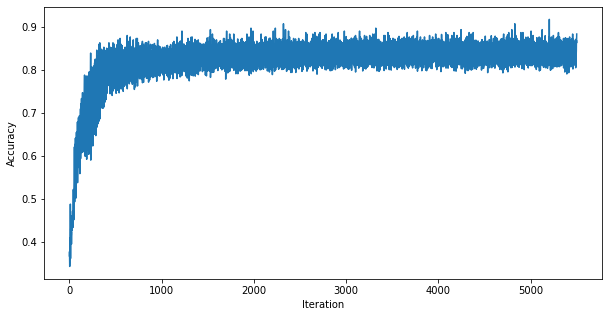

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

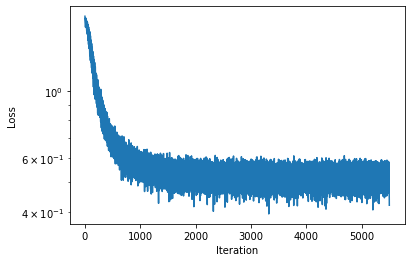

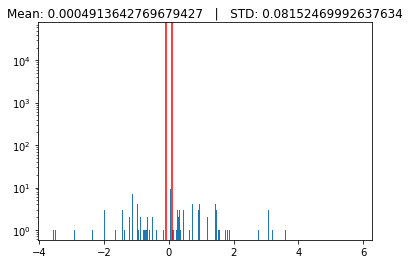

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.517241379310345


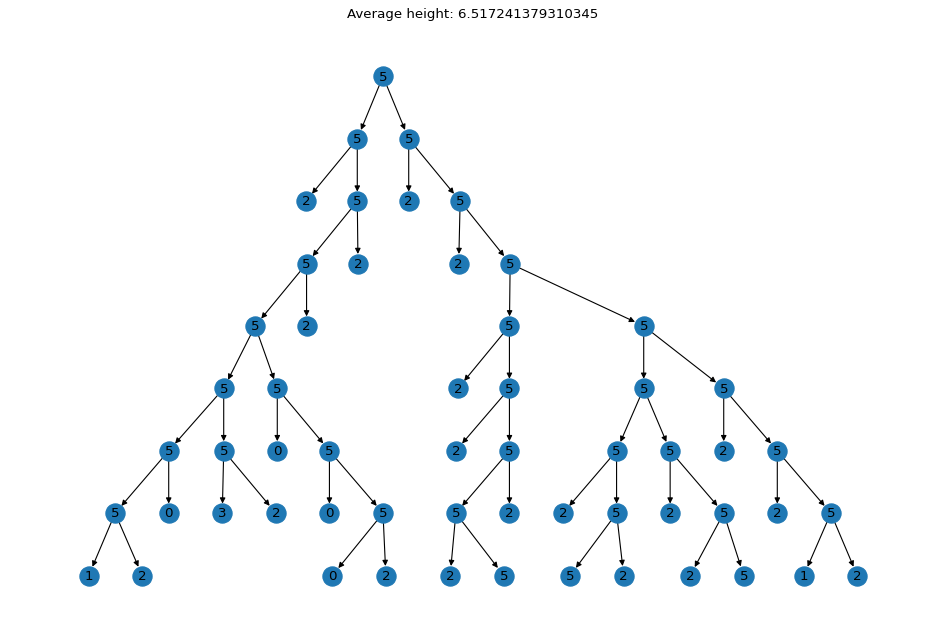

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 29


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()